- Prepare label
- Propensity matching

<Axes: xlabel='sleepage5c', ylabel='Count'>

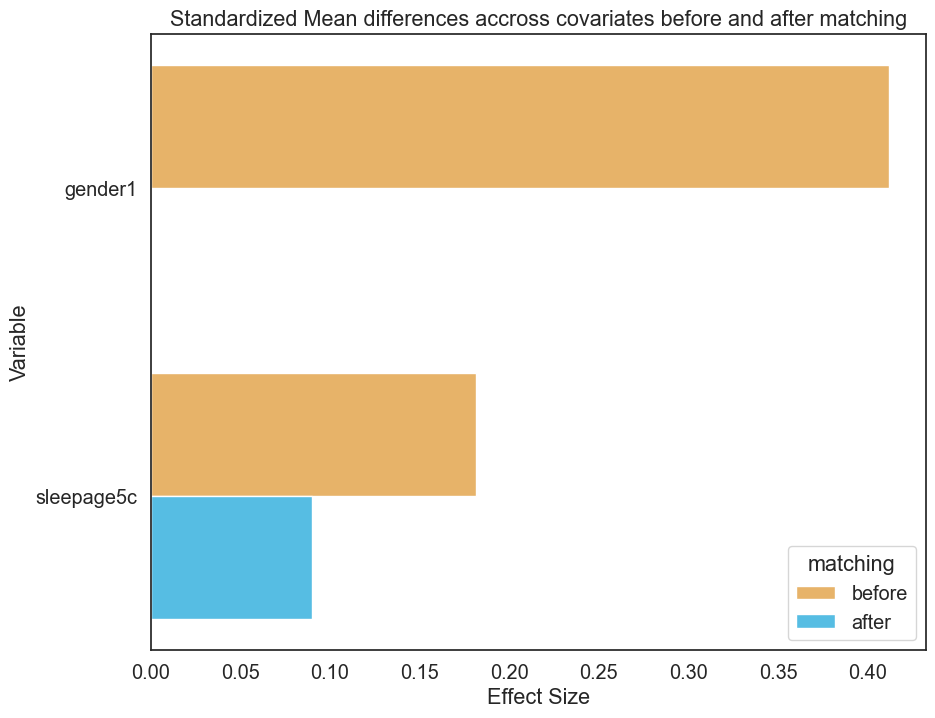

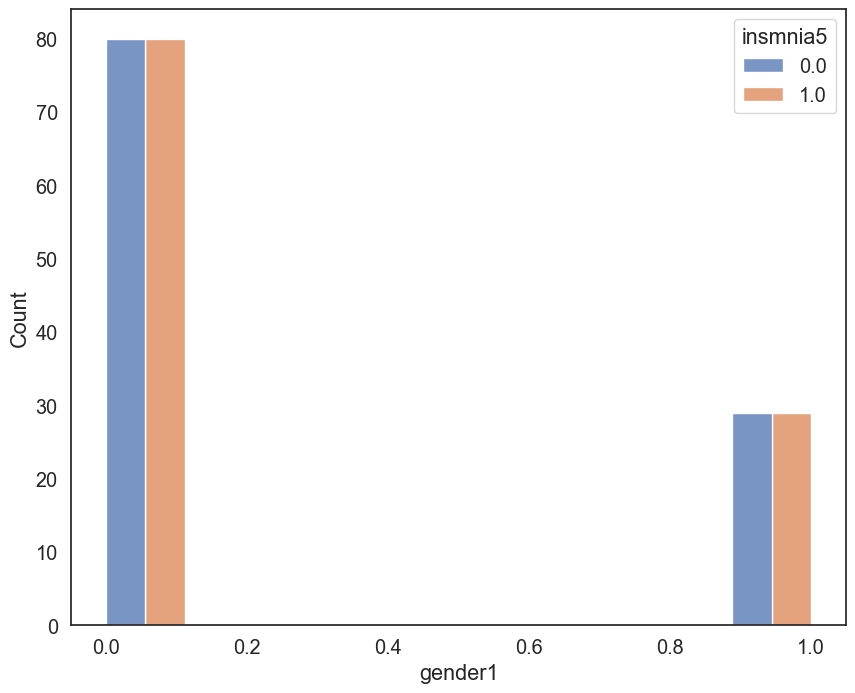

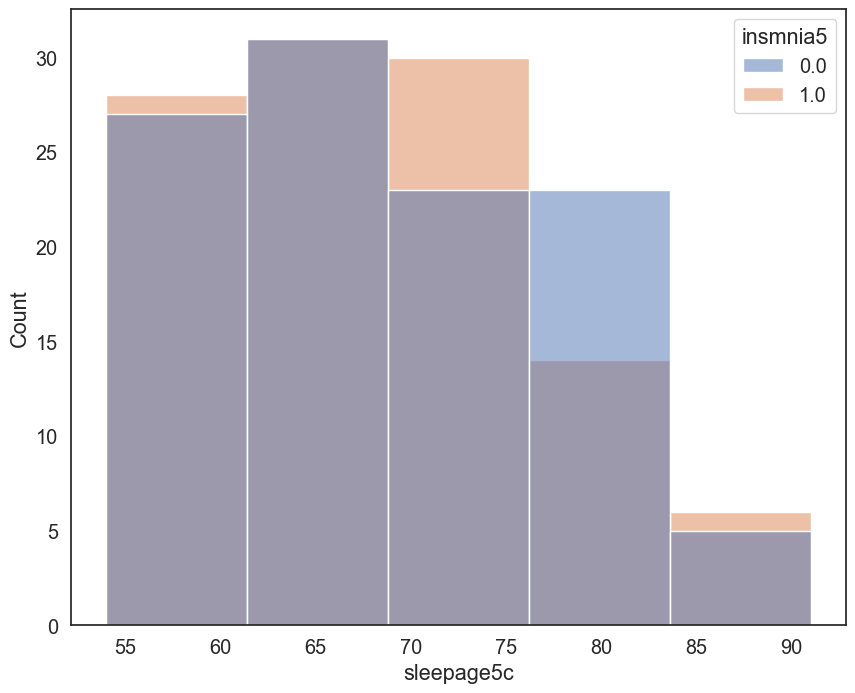

In [29]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psmpy import PsmPy
from psmpy.plotting import *

path_csv = "Y:/MESA_0.7.0/mesa/datasets"
df = pd.read_csv(os.path.join(path_csv, 'mesa-sleep-dataset-0.7.0.csv'), index_col=0)

# OSA, RLS 환자 제외
con_osa = df.slpapnea5 == 1
con_rls = df.rstlesslgs5 == 1
df_excluded = df[~(con_osa | con_rls)]

# Select necessary columns
df_selected = df_excluded.copy().loc[:, ['gender1', 'sleepage5c', 'insmnia5']] # gender1 --> {0: 'Female', 1: 'Male'}

# Remove NaN case
con_not_NaN = pd.Series([True] * len(df_selected), index=df_selected.index)
for column in df_selected.columns:
    con_not_NaN &= ~df_selected[column].isna()
df_selected = df_selected[con_not_NaN]

# Propensity score matching
def get_ids_psm(df_selected, is_plot=False):
    df_selected_psm = df_selected.reset_index(inplace=False, drop=False)

    # Label change. PsmPy는 label이 0인 그룹을 고정한 채로, label이 1인 그룹에서 추출하기 때문
    con_ins_0 = df_selected_psm.insmnia5 == 0
    con_ins_1 = df_selected_psm.insmnia5 == 1
    df_selected_psm.loc[con_ins_0, 'insmnia5'] = 1
    df_selected_psm.loc[con_ins_1, 'insmnia5'] = 0

    # 2. insmnia5가 1인 그룹과 0인 그룹으로 분리
    psm = PsmPy(df_selected_psm, treatment='insmnia5', indx='mesaid', seed=42)

    # 3. Propensity Score 계산 (gender1과 sleepage5c만 포함)
    psm.logistic_ps(balance=True)

    # 4. 매칭 수행 (KNN 방식 사용, caliper=0.05 설정 가능)
    psm.knn_matched_12n(matcher='propensity_score', how_many=1)
    matched_mesaid = psm.df_matched.loc[:, 'mesaid'].values

    if is_plot:
        psm.effect_size_plot()
    return matched_mesaid

matched_mesaid = get_ids_psm(df_selected=df_selected.copy(), is_plot=True)
df_selected_psm = df_selected.loc[matched_mesaid, :]

plt.figure()
sns.histplot(data=df_selected_psm, x='gender1', hue='insmnia5', multiple="dodge")

plt.figure()
sns.histplot(data=df_selected_psm, x='sleepage5c', hue='insmnia5', bins=5)

<Axes: xlabel='sleepage5c', ylabel='Count'>

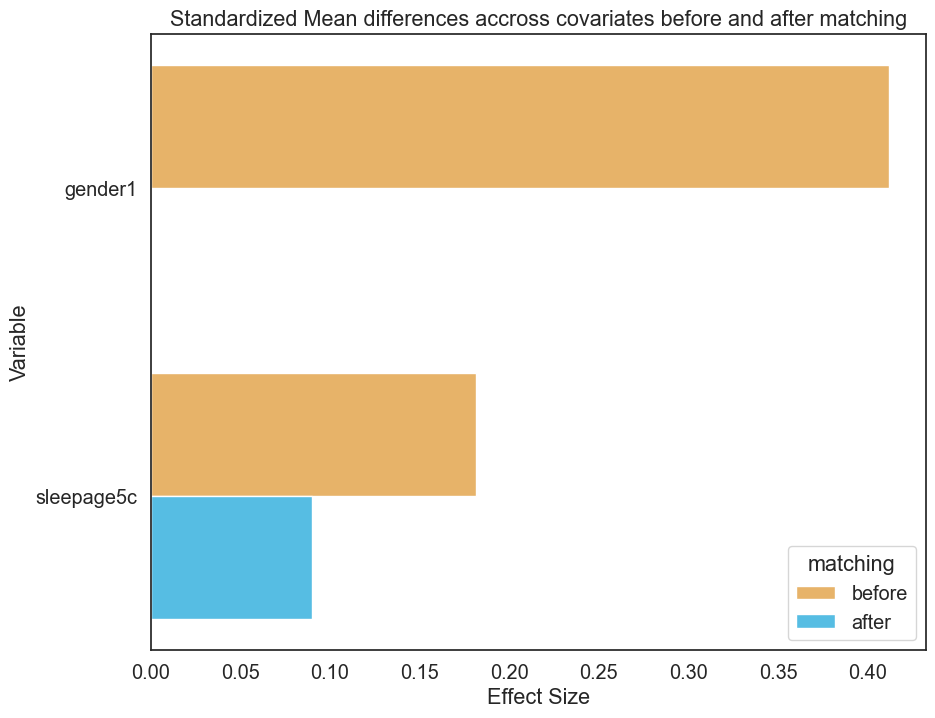

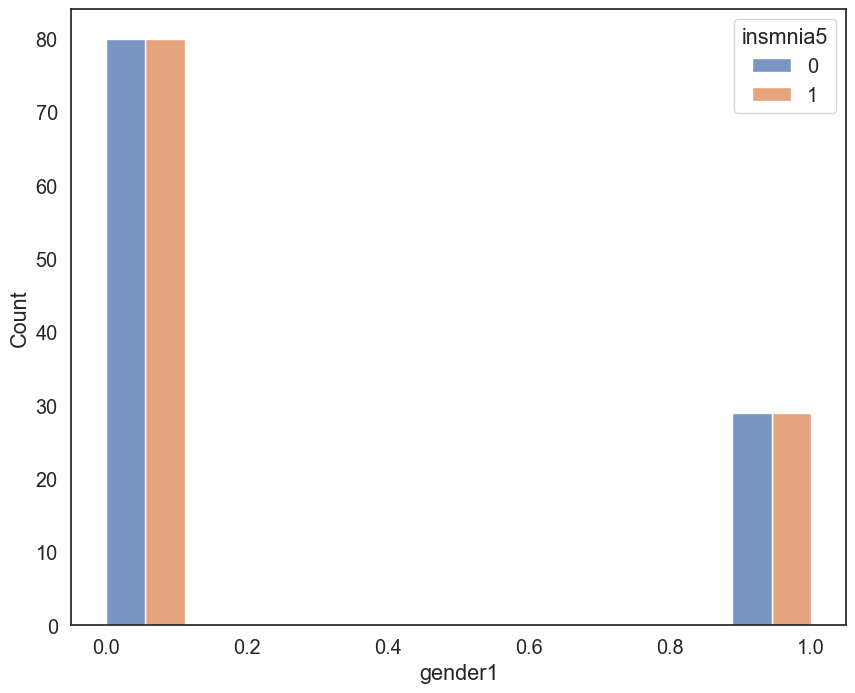

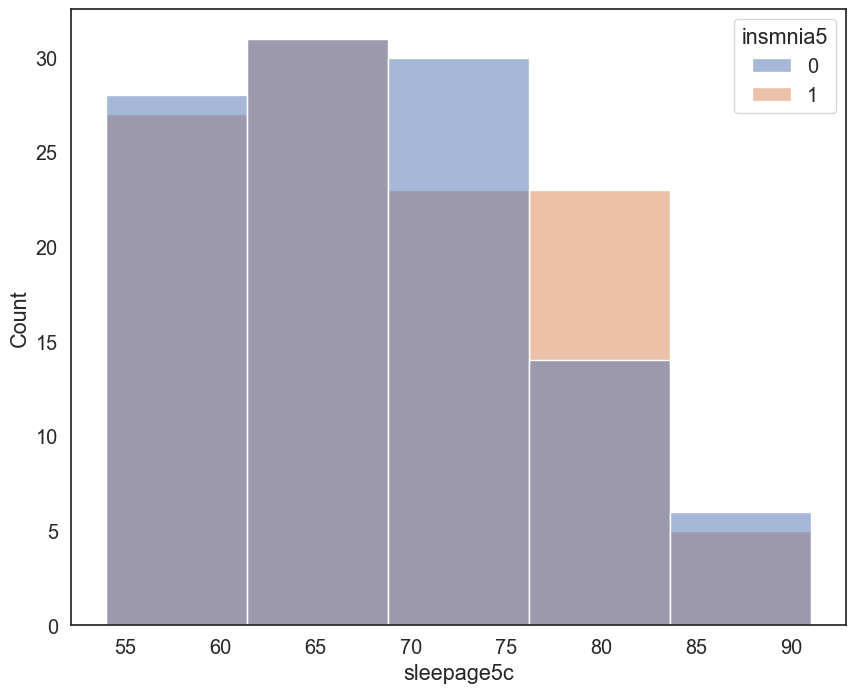

In [22]:
df_selected_psm = df_selected.reset_index(inplace=False, drop=False)

# Label change. PsmPy는 label이 0인 그룹을 고정한 채로, label이 1인 그룹에서 추출하기 때문
con_ins_0 = df_selected_psm.insmnia5 == 0
con_ins_1 = df_selected_psm.insmnia5 == 1
df_selected_psm.loc[con_ins_0, 'insmnia5'] = 1
df_selected_psm.loc[con_ins_1, 'insmnia5'] = 0

# 2. insmnia5가 1인 그룹과 0인 그룹으로 분리
psm = PsmPy(df_selected_psm, treatment='insmnia5', indx='mesaid', seed=42)

# 3. Propensity Score 계산 (gender1과 sleepage5c만 포함)
psm.logistic_ps(balance=True)

# 4. 매칭 수행 (KNN 방식 사용, caliper=0.05 설정 가능)
# psm.knn_matched(matcher='propensity_score', replacement=False, caliper=0.05)
psm.knn_matched_12n(matcher='propensity_score', how_many=1)
matched_mesaid = psm.df_matched.loc[(psm.df_matched.insmnia5 == 1), 'mesaid'].values

# 5. 시각화
plt.figure()
psm.effect_size_plot()

plt.figure()
sns.histplot(data=psm.df_matched, x='gender1', hue='insmnia5', multiple="dodge")

plt.figure()
sns.histplot(data=psm.df_matched, x='sleepage5c', hue='insmnia5', bins=5)

In [ ]:
(df_selected.insmnia5 == 1).sum()

np.int64(109)

In [6]:
df_matched = psm.df_matched.copy()
df_matched.insmnia5 = df_matched.insmnia5.astype(str)

<Axes: xlabel='gender1', ylabel='Count'>

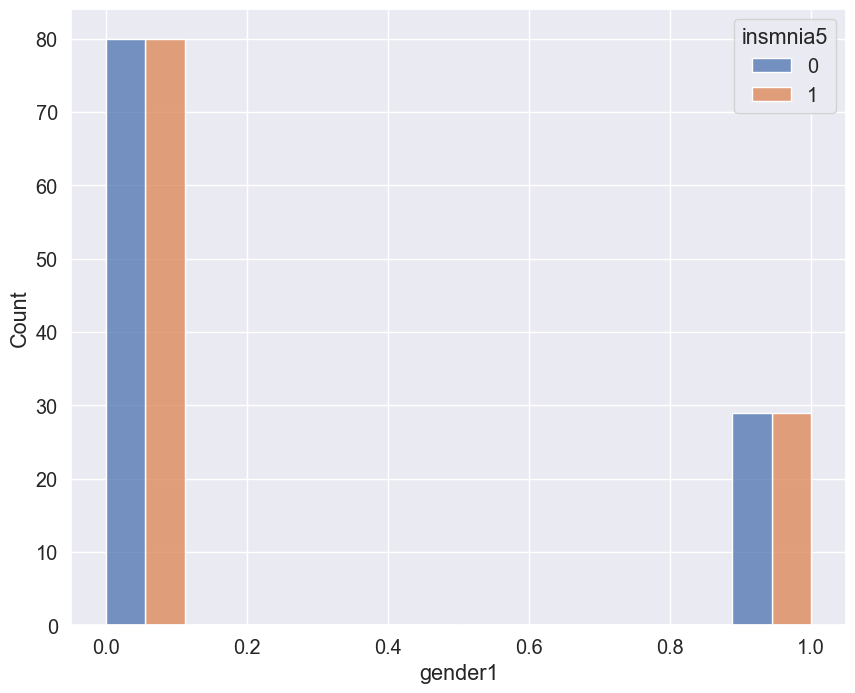

In [13]:
sns.histplot(data=psm.df_matched, x='gender1', hue='insmnia5', multiple="dodge")

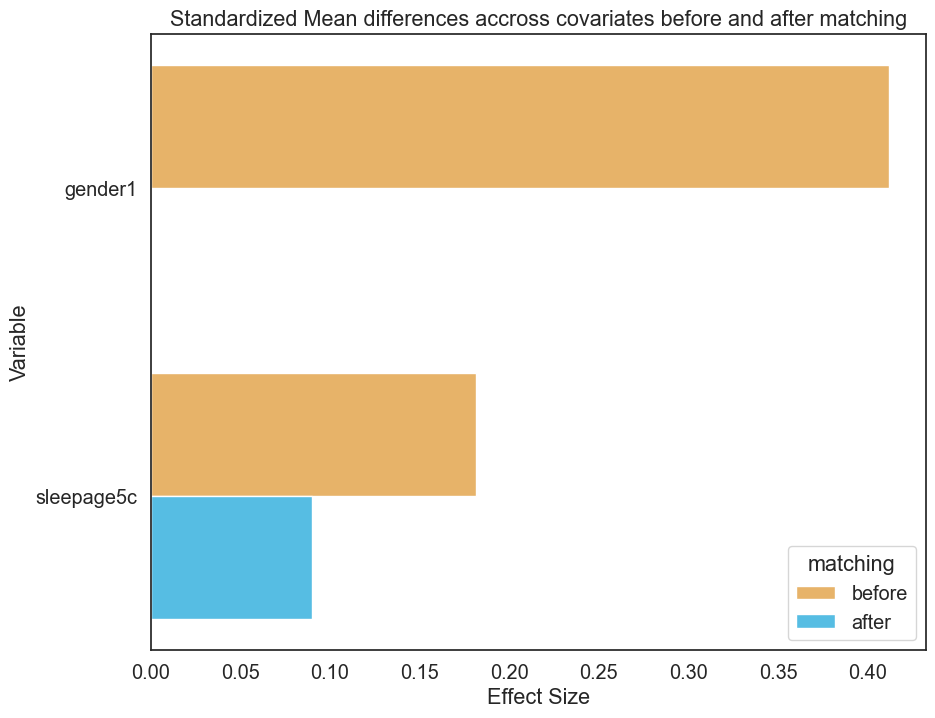

In [36]:
psm.effect_size_plot()

In [35]:
len(matched_mesaid)

109

In [34]:
df_selected.loc[matched_mesaid[0], ]

gender1        0.0
sleepage5c    70.0
insmnia5       0.0
Name: 2488, dtype: float64

In [ ]:
matched_mesaid = psm.matched_ids['mesaid'].values   

In [30]:
psm.df_matched

,mesaid,gender1,sleepage5c,propensity_score,propensity_logit,insmnia5
0,168,0,63,0.420930,-0.318955,0
1,179,0,75,0.439810,-0.241935,0
2,248,0,69,0.430243,-0.280859,0
3,275,1,59,0.610607,0.449863,0
4,295,0,62,0.419418,-0.325165,0
...,...,...,...,...,...,...
213,5009,0,74,0.431381,-0.276218,1
214,1058,0,72,0.437672,-0.250615,1
215,3500,1,56,0.635763,0.557021,1
216,214,0,88,0.433230,-0.268687,1


In [29]:
psm.matched_ids

,mesaid,largerclass_0group
0,168,2488
1,179,5196
2,248,6509
3,275,6382
4,295,4292
...,...,...
104,6607,5009
105,6686,1058
106,6699,3500
107,6746,214


99


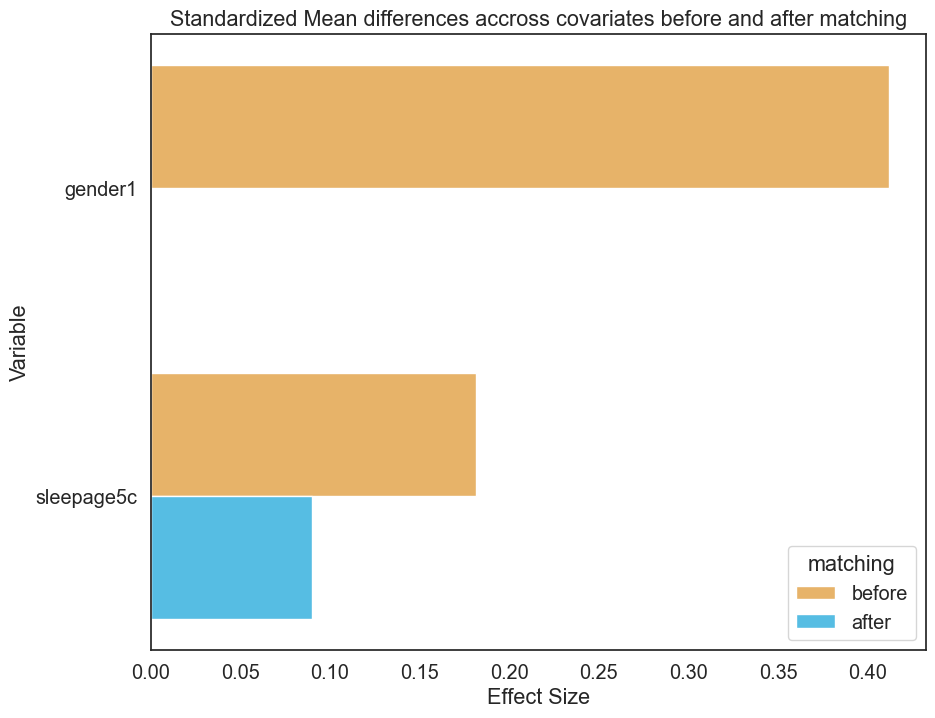

In [ ]:
df_selected_psm = df_selected.reset_index(inplace=False, drop=False)

# Label change. PsmPy는 label이 0인 그룹을 고정한 채로, label이 1인 그룹에서 추출하기 때문
# con_ins_0 = df_selected_psm.insmnia5 == 0
# con_ins_1 = df_selected_psm.insmnia5 == 1
# df_selected_psm.loc[con_ins_0, 'insmnia5'] = 1
# df_selected_psm.loc[con_ins_1, 'insmnia5'] = 0

# 2. insmnia5가 1인 그룹과 0인 그룹으로 분리
psm = PsmPy(df_selected_psm, treatment='insmnia5', indx='mesaid', seed=42)

# 3. Propensity Score 계산 (gender1과 sleepage5c만 포함)
psm.logistic_ps(balance=True)

# 4. 매칭 수행 (KNN 방식 사용, caliper=0.05 설정 가능)
# psm.knn_matched(matcher='propensity_score', replacement=False, caliper=0.05)
psm.knn_matched_12n(matcher='propensity_score', how_many=1)

# 5. 매칭 결과 확인
# matched_mesaid = psm.matched_ids['mesaid'].values
print(len(matched_mesaid))

# # 6. 결과 출력
# print("매칭된 데이터:")
# print(matched_df_selected)

# # 7. 시각화 (선택사항)
psm.effect_size_plot()


In [ ]:
psm.df_matched.

,mesaid,gender1,sleepage5c,propensity_score,propensity_logit,insmnia5
0,248,0,69,0.577670,0.313215,1
1,275,1,59,0.371490,-0.525829,1
2,295,0,62,0.583564,0.337421,1
3,319,0,75,0.570485,0.283832,1
4,350,0,71,0.575821,0.305643,1
...,...,...,...,...,...,...
193,6583,0,78,0.568587,0.276089,0
194,4230,0,58,0.576813,0.309702,0
195,2375,0,75,0.571496,0.287958,0
196,6238,0,62,0.575797,0.305543,0


In [33]:
df_selected.loc[248, :]

gender1        0.0
sleepage5c    69.0
insmnia5       1.0
whiirs5c      10.0
qupleth5       3.0
Name: 248, dtype: float64

In [ ]:
propensity score matching을 파이썬ㅇㅔ서 구현하고 싶어.

아래는 내가 가지고 있는 데이터 프레임이야.

	gender1	sleepage5c	insmnia5	whiirs5c	qupleth5
mesaid					
1	0	70	0.0	10.0	4.0
2	0	83	0.0	10.0	5.0
6	0	57	0.0	14.0	5.0
12	1	80	0.0	8.0	5.0
14	0	60	0.0	8.0	5.0
...	...	...	...	...	...
6802	0	65	0.0	3.0	5.0
6804	0	77	0.0	2.0	5.0
6810	1	77	0.0	11.0	5.0
6811	1	79	0.0	7.0	5.0
6812	0	68	0.0	8.0	5.0
1962 rows × 5 columns

insmnia5가 1인 그룹의 gender1과 sleepage5c가 matching되는 insmnia5가 0인 그룹을 만들어줘.